<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

### **Task II: Hyperspectral Regression: Chlorophyll Content Prediction**  
**Author: Ramesh Bhatta, CIS, RIT**  
**Github Repo: https://github.com/Bhatta6190/Machine-Learning-in-Remote-Sensing/tree/main/HSI-classification-regression/Regression**  

</div>

<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

---
---

### **Task Definition**  

In this task we we will use the dataset (*landis_chlorophyl_regression.npy* and *landis_chlorophyl_regression_gt.npy*) generated from a combination of the *PROSPECT* radiative transfer model for leaf reflectance spectra at varying chlorophyll levels and *MODTRAN* for forward modeling the spectral data to simulate observations from the *Landsat* next satellite. Ten bands in the visible to near-infrared region has been selected for the purpose of this problem. The bands are as below:

| Band Name    | Center Wavelength (nm) |
|-------------|:-----------------------:|
| Blue        | 490                   |
| Green       | 560                   |
| Yellow      | 600                   |
| Orange      | 620                   |
| Red 1       | 650                   |
| Red 2       | 665                   |
| Red Edge 1  | 705                   |
| Red Edge 2  | 740                   |
| NIR_Broad   | 842                   |
| NIR1        | 865                   |

The dataset includes 1000 samples with 10 spectral bands, along with the corresponding chlorophyll content obtained from the original Prospect simulation. This dataset presents a regression task where the goal is to predict chlorophyll content using the spectral band values as features. Specifically following tasks will be performed:

- **Exploratory Data Analysis (EDA)**

- **Regression Models:**
    - *Linear Regression*, 
    - *Partial Least Square Regression (PLSR)* and 
    - *Multi-Layer Perceptron (MLP)* models
---
---
</div>


In [60]:
## Importing necessary packages

import numpy as np
import scipy.io  
import matplotlib.pyplot as plt  
import seaborn as sns  

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [61]:
## Predefined plot preferences

# Define text sizes
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

# Apply text size settings
plt.rc('font', size=SMALL_SIZE)          # Default font size
plt.rc('axes', titlesize=MEDIUM_SIZE)   # Axis title font size
plt.rc('axes', labelsize=MEDIUM_SIZE)   # Axis labels font size
plt.rc('xtick', labelsize=SMALL_SIZE)   # X-axis tick label font size
plt.rc('ytick', labelsize=SMALL_SIZE)   # Y-axis tick label font size
plt.rc('legend', fontsize=SMALL_SIZE)   # Legend font size
plt.rc('figure', titlesize=BIGGER_SIZE) # Figure title font size

<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

---
---

### **Exploratory Data Analysis (EDA)**


</div>


In [62]:
## Importing the Datasets

landis_data = np.load('./landis_chlorophyl_regression.npy')      # Spectral data(1000 samples, 10 bands)
chlorphyl_gt = np.load('./landis_chlorophyl_regression_gt.npy')  # Actual chlorophyll content

In [75]:
landis_data.shape

(1000, 10)

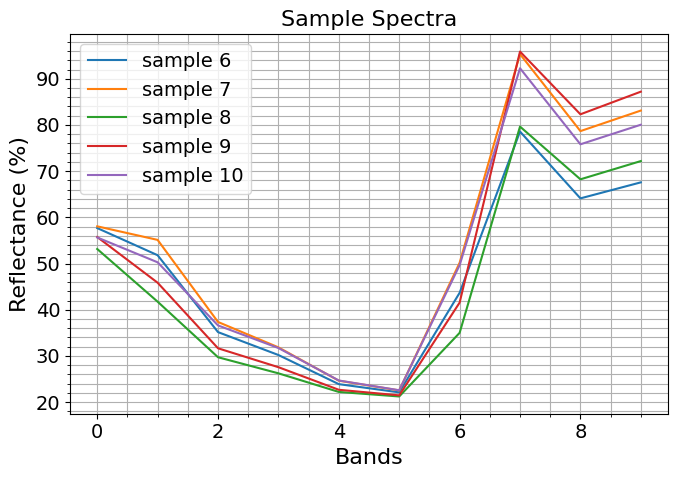

In [88]:
## Plot the data samples:

# Plot the correlation matrix
plt.figure(figsize=(7, 5))
for i in range(5, 10):   ## Plot 5 samples
    plt.plot(landis_data[i,:], label=f'sample {i+1}')
plt.title("Sample Spectra")
plt.ylabel("Reflectance (%)")
plt.xlabel("Bands")
plt.legend()
plt.grid(which='both')
plt.minorticks_on()
plt.tight_layout()
plt.show()


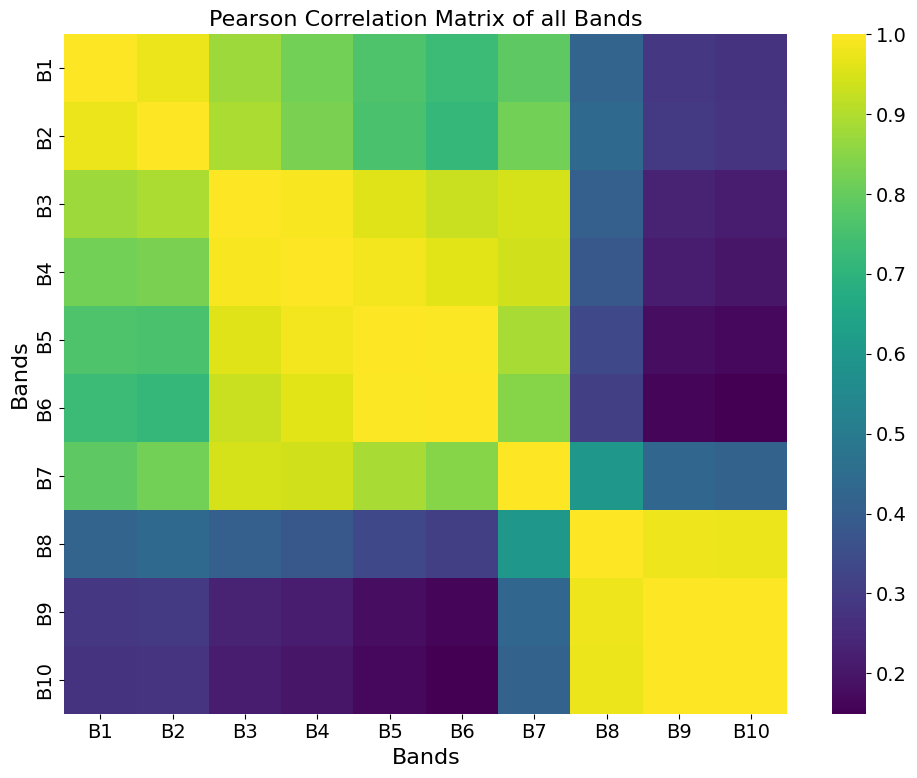

In [63]:
## Data Exploration:

# Function to compute correlation matrix

def correlation_matrix(band_data):
    bands = band_data.shape[1]
    reshaped_data = band_data.reshape(-1, bands)  # Ensure correct shape
    reshaped_data = reshaped_data[~np.isnan(reshaped_data).any(axis=1)]  # Remove NaN values
    corr_matrix = np.corrcoef(reshaped_data.T)  # Transpose to get correct correlation
    return corr_matrix

# Compute the correlation matrix for spectral data
corr_matrix = correlation_matrix(landis_data)

# Generate tick labels for bands
xticks = [f'B{i+1}' for i in range(landis_data.shape[1])]
step = max(1, len(xticks) // 10) 
xticks_labels = [xticks[i] if i % step == 0 else "" for i in range(len(xticks))]

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="viridis", cbar=True,
            xticklabels=xticks_labels, yticklabels=xticks_labels)
plt.title("Pearson Correlation Matrix of all Bands")
plt.xlabel("Bands")
plt.ylabel("Bands")
plt.tight_layout()
plt.show()


<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

**Comments: Multicollinearity**  

From the above correlation matrix plot we can clearly see the cluster of high correlation bands in the plot. Specially the bands within range *B1 and B2*, *B3-B7* and *B8-B10* show high degree of correlation. So selection of subset of these bands is important for better modeling of chlorophyl content from spectral data.

</div>

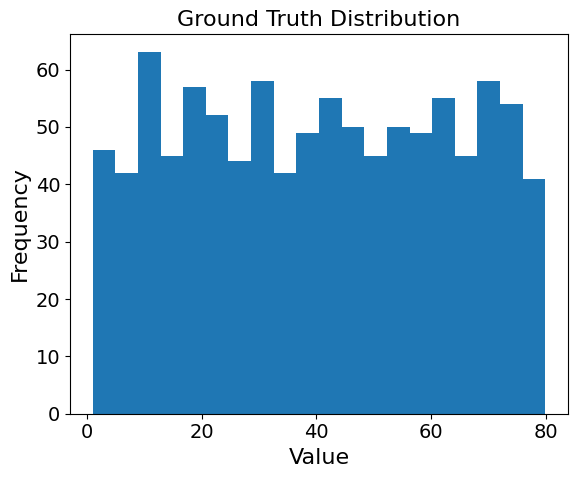

In [64]:
## Ground Truth Distribution

plt.figure(figsize=(6, 5))
plt.hist(chlorphyl_gt, bins=20)
plt.title("Ground Truth Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

**Comments: Target variable distribution** 

The distribution of values in the target variable is fairly even- which means the regression model will be trained on the samples without getting biased by *Majority Samples*. Thus no need of balancing is required in this case.

</div>

<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

---
---

### **Linear Regression**


</div>


In [65]:
## Split the data into 80-20 train-test sets i.e. 80% train and 20% test samples:

# Standarize the data
scaler = StandardScaler()
X = scaler.fit_transform(landis_data)
y = chlorphyl_gt

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Prediction
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

## Performance Metrics Calculations

# Function to calculate MAE, R-Squared and Standard deviation of Residuals
def performance_metrics(actual, predicted):
    MAE = mean_absolute_error(actual, predicted)
    R2 = r2_score(actual, predicted)
    residuals_std = np.nanstd(actual-predicted)

    return MAE, R2, residuals_std

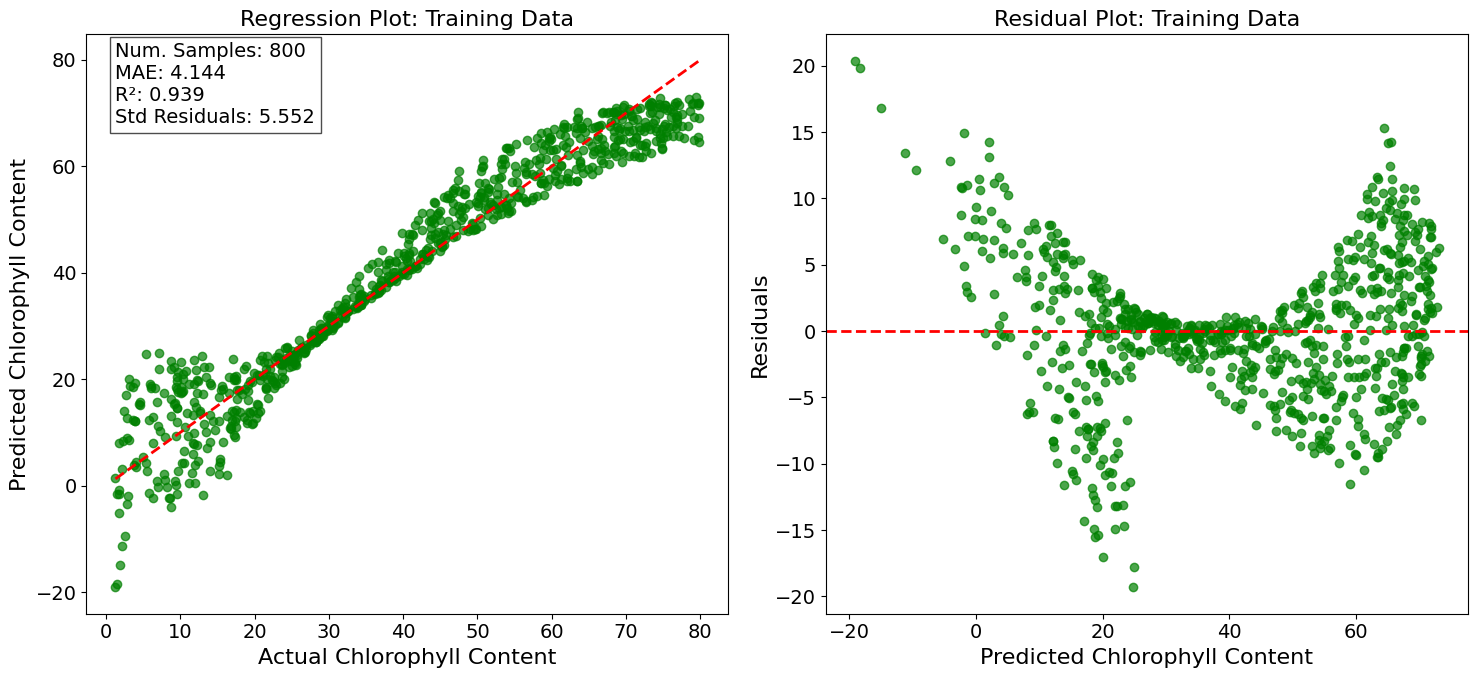

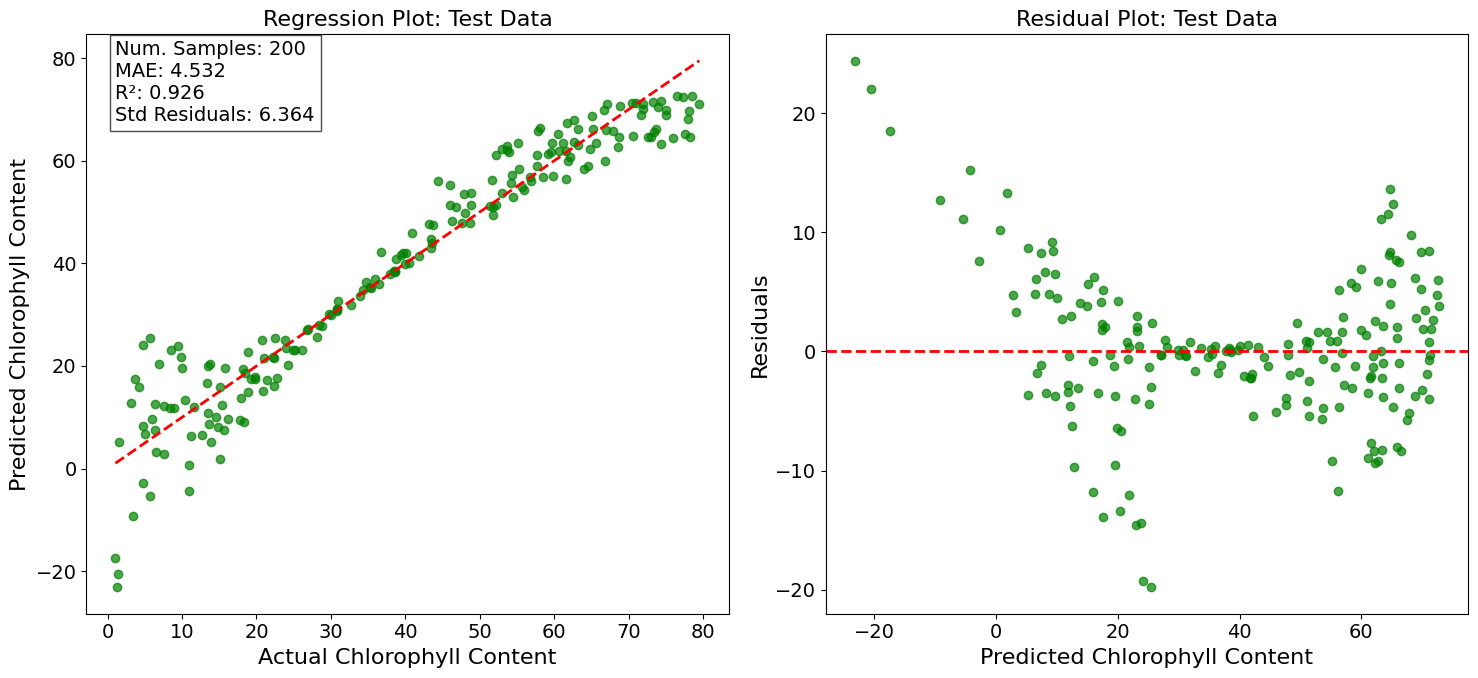

In [66]:
## Showing the Model Performance:

# Train Set:

MAE_train, R2_train, residual_std_train = performance_metrics(y_train, y_train_pred) # based on prediction of training data
residuals_train = y_train - y_train_pred

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].scatter(y_train, y_train_pred, alpha=0.7, color='green')
ax[0].set_title("Regression Plot: Training Data")
ax[0].text(min(y_train), max(y_train_pred)-5, 
                    f"Num. Samples: {len(X_train)}\nMAE: {MAE_train:.3f}\nR²: {R2_train:.3f}\nStd Residuals: {residual_std_train:.3f}", 
                    bbox=dict(facecolor='white', alpha=0.7))
ax[0].plot([min(y_train), max(y_train)], 
                    [min(y_train), max(y_train)], 
                    color='red', linestyle='--', linewidth=2)
ax[0].set_xlabel('Actual Chlorophyll Content')
ax[0].set_ylabel('Predicted Chlorophyll Content')

ax[1].scatter(y_train_pred, residuals_train, alpha=0.7, color='green')
ax[1].axhline(0, color='red', linestyle='--', linewidth=2)
ax[1].set_title("Residual Plot: Training Data")
ax[1].set_xlabel('Predicted Chlorophyll Content')
ax[1].set_ylabel('Residuals')
plt.tight_layout()
plt.show()

# Test Set:

MAE_test, R2_test, residual_std_test = performance_metrics(y_test, y_test_pred) # based on prediction of testing data
residuals_test = y_test - y_test_pred

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].scatter(y_test, y_test_pred, alpha=0.7, color='green')
ax[0].set_title("Regression Plot: Test Data")
ax[0].text(min(y_test), max(y_test_pred)-5, 
                    f"Num. Samples: {len(X_test)}\nMAE: {MAE_test:.3f}\nR²: {R2_test:.3f}\nStd Residuals: {residual_std_test:.3f}", 
                    bbox=dict(facecolor='white', alpha=0.7))
ax[0].plot([min(y_test), max(y_test)], 
                    [min(y_test), max(y_test)], 
                    color='red', linestyle='--', linewidth=2)
ax[0].set_xlabel('Actual Chlorophyll Content')
ax[0].set_ylabel('Predicted Chlorophyll Content')

ax[1].scatter(y_test_pred, residuals_test, alpha=0.7, color='green')
ax[1].axhline(0, color='red', linestyle='--', linewidth=2)
ax[1].set_title("Residual Plot: Test Data")
ax[1].set_xlabel('Predicted Chlorophyll Content')
ax[1].set_ylabel('Residuals')
plt.tight_layout()
plt.show()

<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

**Comments: Linear Regression Model** 

We trained a **Linear Regression Model** on our 10 bands Landsat data (simulated) to predict the chlorophyll content in the samples. First the samples are divided into 80-20 training-testing subsets and then linear regression model is trained on the *Train set* and tested on *Test set*. The linear regression model assumes that the target variables is the linear combination of predictor variables (bands in this case). The outcome of the model is shown in plots above. The regression plot shows reliable model with a clear trend among predicted and actual chlorophyll content both in train and test data. [*MAE*, *R2*] for training set and testing set are [4.144, 0.939] and [4.532, 0.926] respectively. Thus both in training and test set over 90% variance in chlorophyll content can be explained by the model. However when we look at the residual plot we can see the non-linearity in the residuals. This shows the presence of inherent non-linearity predictions. This suggests that a more complex non-linear relation between the band data and the target variable and the need of better model for regression.  

</div>

<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

---
---

### **Partial Least Square Regresssion (PLSR)**


</div>


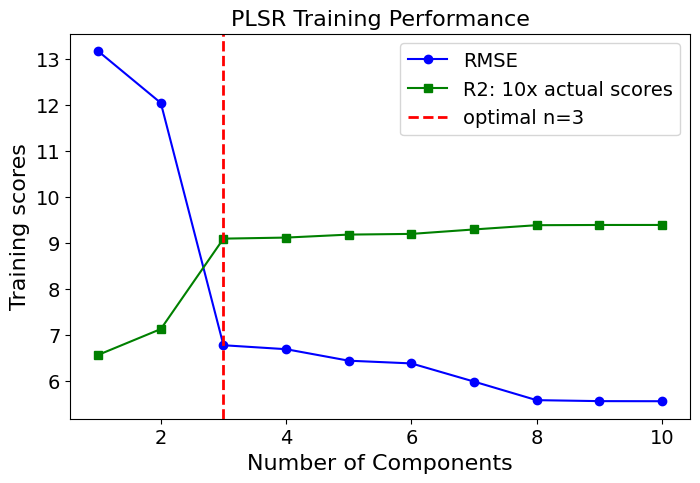

In [67]:
# Determine the optimal number of components

# Performance metrics: R-Squared and RMSE

R_squares = []
RMSE = []

for i in range(1, 11):

    pls = PLSRegression(n_components= i)
    pls.fit(X_train, y_train)
    y_train_pred = pls.predict(X_train)
    
    # Compute R2 and RMSE
    rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    R_squares.append(r2_score(y_train, y_train_pred )*10)          # Scaled by 10 for visualization
    RMSE.append(rmse)

# Plot the metrics scores
plt.figure(figsize=(8, 5))
plt.plot([i+1 for i in range(10)], RMSE, marker='o', linestyle='-', color='b', label='RMSE')
plt.plot([i+1 for i in range(10)], R_squares, marker='s', linestyle='-', color='g', label='R2: 10x actual scores')
plt.axvline(3, color='r', linestyle='--', linewidth=2, label='optimal n=3')
plt.xlabel('Number of Components')
plt.ylabel('Training scores')
plt.title('PLSR Training Performance')
plt.legend()
# plt.grid(which='both')
# plt.minorticks_on()
plt.show()

<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

**Comments: Optimal Number of Components** 

The plot above shows the training performance of *Partial Least Square Regression Algorithm (PLSR)* in terms of RMSE and R-Squared metrics. *PLSR* is similar to *PCA* in that it performs dimensionality reduction, but unlike PCA, it prioritizes components that maximize the differentiability of the target variable. As we can see that after *n=3* there is not much improvement in *RMSE* and *R2* values, thus we choose *n=3* as the optimal number of components for our regression.
</div>

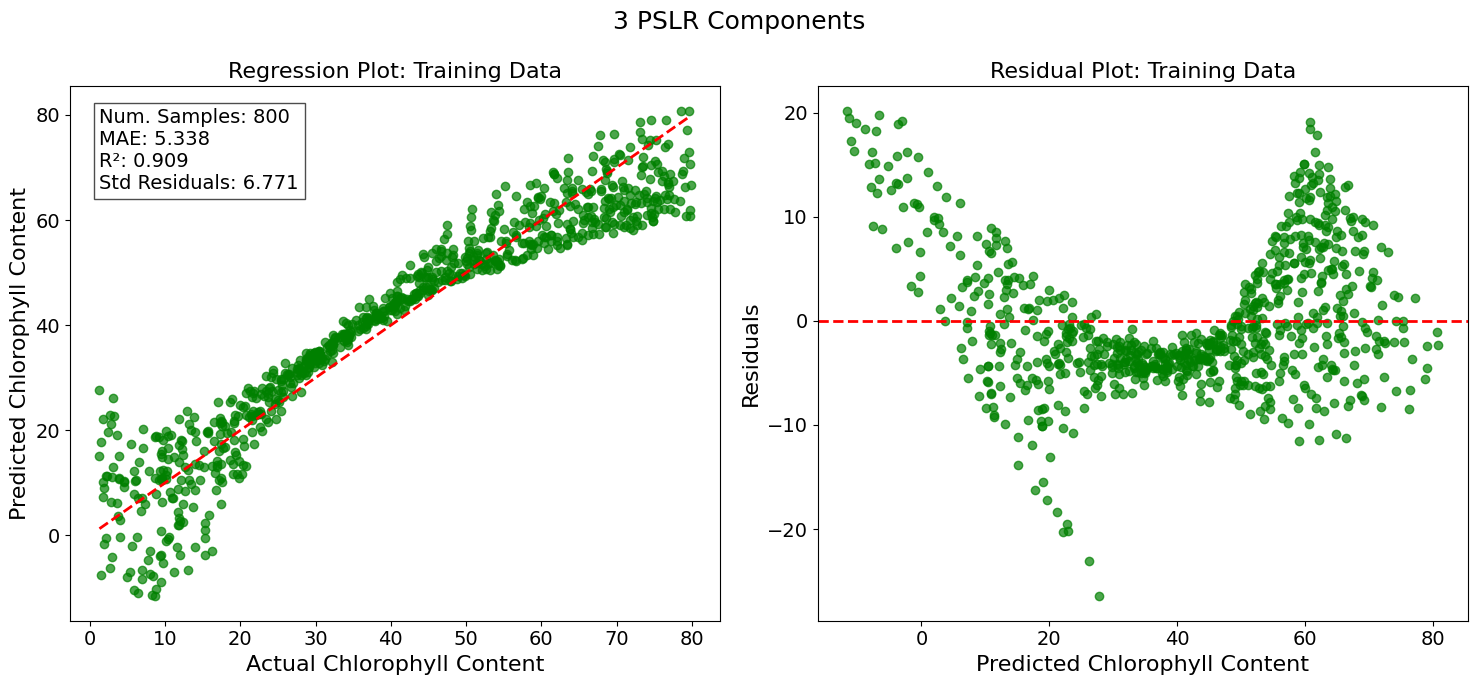

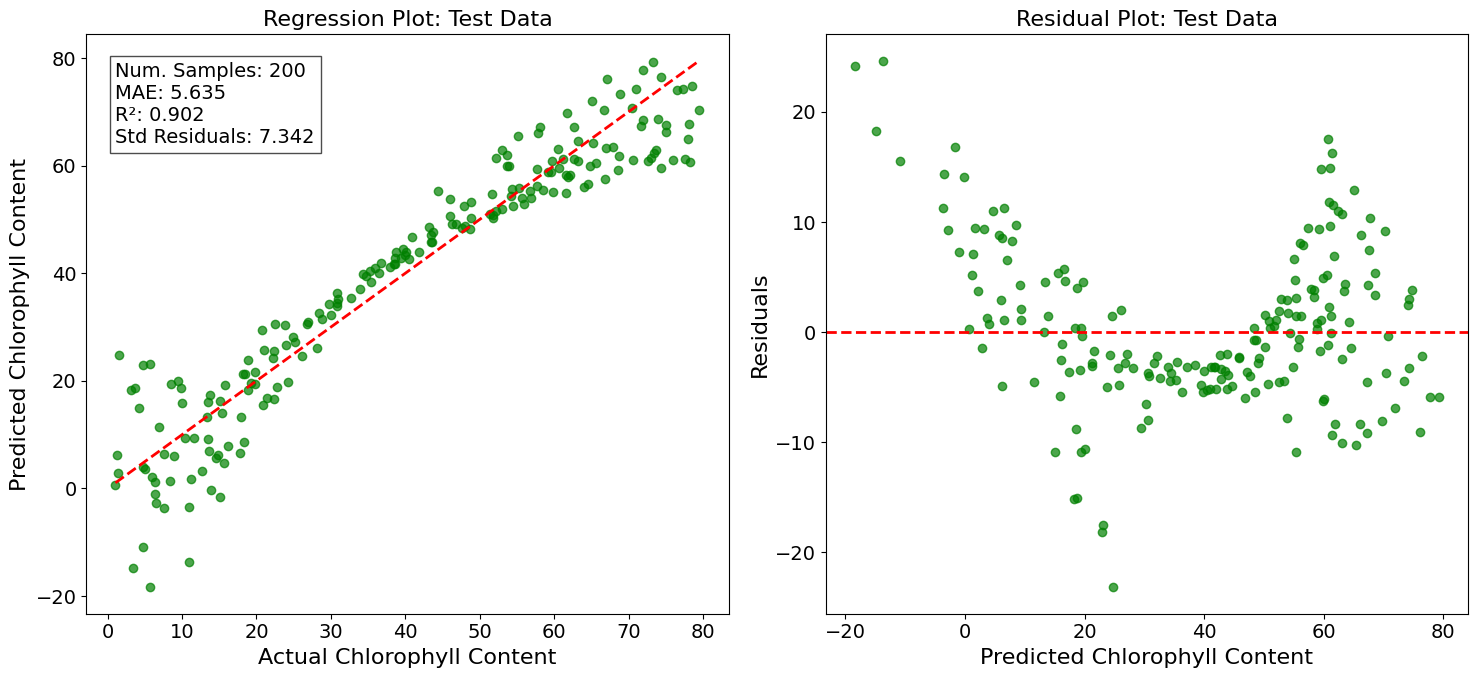

In [68]:
## Model Predictions

## Train Set Predictions:

number_of_components = 3
pls_best = PLSRegression(n_components=number_of_components)
pls_best.fit(X_train, y_train)

# Predictions
y_train_pred = pls_best.predict(X_train)
MAE_train, R2_train, residual_std_train = performance_metrics(y_train, y_train_pred) # based on prediction of training data
residuals_train = y_train - y_train_pred

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].scatter(y_train, y_train_pred, alpha=0.7, color='green')
ax[0].set_title("Regression Plot: Training Data")
ax[0].text(min(y_train), max(y_train_pred)-15, 
                    f"Num. Samples: {len(X_train)}\nMAE: {MAE_train:.3f}\nR²: {R2_train:.3f}\nStd Residuals: {residual_std_train:.3f}", 
                    bbox=dict(facecolor='white', alpha=0.7))
ax[0].plot([min(y_train), max(y_train)], 
                    [min(y_train), max(y_train)], 
                    color='red', linestyle='--', linewidth=2)
ax[0].set_xlabel('Actual Chlorophyll Content')
ax[0].set_ylabel('Predicted Chlorophyll Content')

ax[1].scatter(y_train_pred, residuals_train, alpha=0.7, color='green')
ax[1].axhline(0, color='red', linestyle='--', linewidth=2)
ax[1].set_title("Residual Plot: Training Data")
ax[1].set_xlabel('Predicted Chlorophyll Content')
ax[1].set_ylabel('Residuals')
plt.suptitle(f"{number_of_components} PSLR Components")
plt.tight_layout()
plt.show()

## Test Set Prediction

y_test_pred = pls_best.predict(X_test)

MAE_test, R2_test, residual_std_test = performance_metrics(y_test, y_test_pred) # based on prediction of testing data
residuals_test = y_test - y_test_pred

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].scatter(y_test, y_test_pred, alpha=0.7, color='green')
ax[0].set_title("Regression Plot: Test Data")
ax[0].text(min(y_test), max(y_test_pred)-15, 
                    f"Num. Samples: {len(X_test)}\nMAE: {MAE_test:.3f}\nR²: {R2_test:.3f}\nStd Residuals: {residual_std_test:.3f}", 
                    bbox=dict(facecolor='white', alpha=0.7))
ax[0].plot([min(y_test), max(y_test)], 
                    [min(y_test), max(y_test)], 
                    color='red', linestyle='--', linewidth=2)
ax[0].set_xlabel('Actual Chlorophyll Content')
ax[0].set_ylabel('Predicted Chlorophyll Content')

ax[1].scatter(y_test_pred, residuals_test, alpha=0.7, color='green')
ax[1].axhline(0, color='red', linestyle='--', linewidth=2)
ax[1].set_title("Residual Plot: Test Data")
ax[1].set_xlabel('Predicted Chlorophyll Content')
ax[1].set_ylabel('Residuals')
plt.tight_layout()
plt.show()


<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

**Comments: PLSR predictions** 

Taking just 3 *PLSR* components still gives us dependable result with low training and testing *MAE* and high *R2 (>90%)* values. Such data reduction technique can be important where relatively lower number of samples can be used to train a model due to reduced band dimensions- from 10 to just 3. There is still a non-linearity component which our model cannot resolve and this can be seen clearly in the residual plots. The residuals for lower and higher predicted values are much higher than the in-between values. Thus *PLSR* is able to reduce the dimension efficiently but cannot improve model in adjusting non-linearity in the predictions. 

</div>

<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

---
---

### **Multi-Layer Perceptron (MLP) Regression**


</div>


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


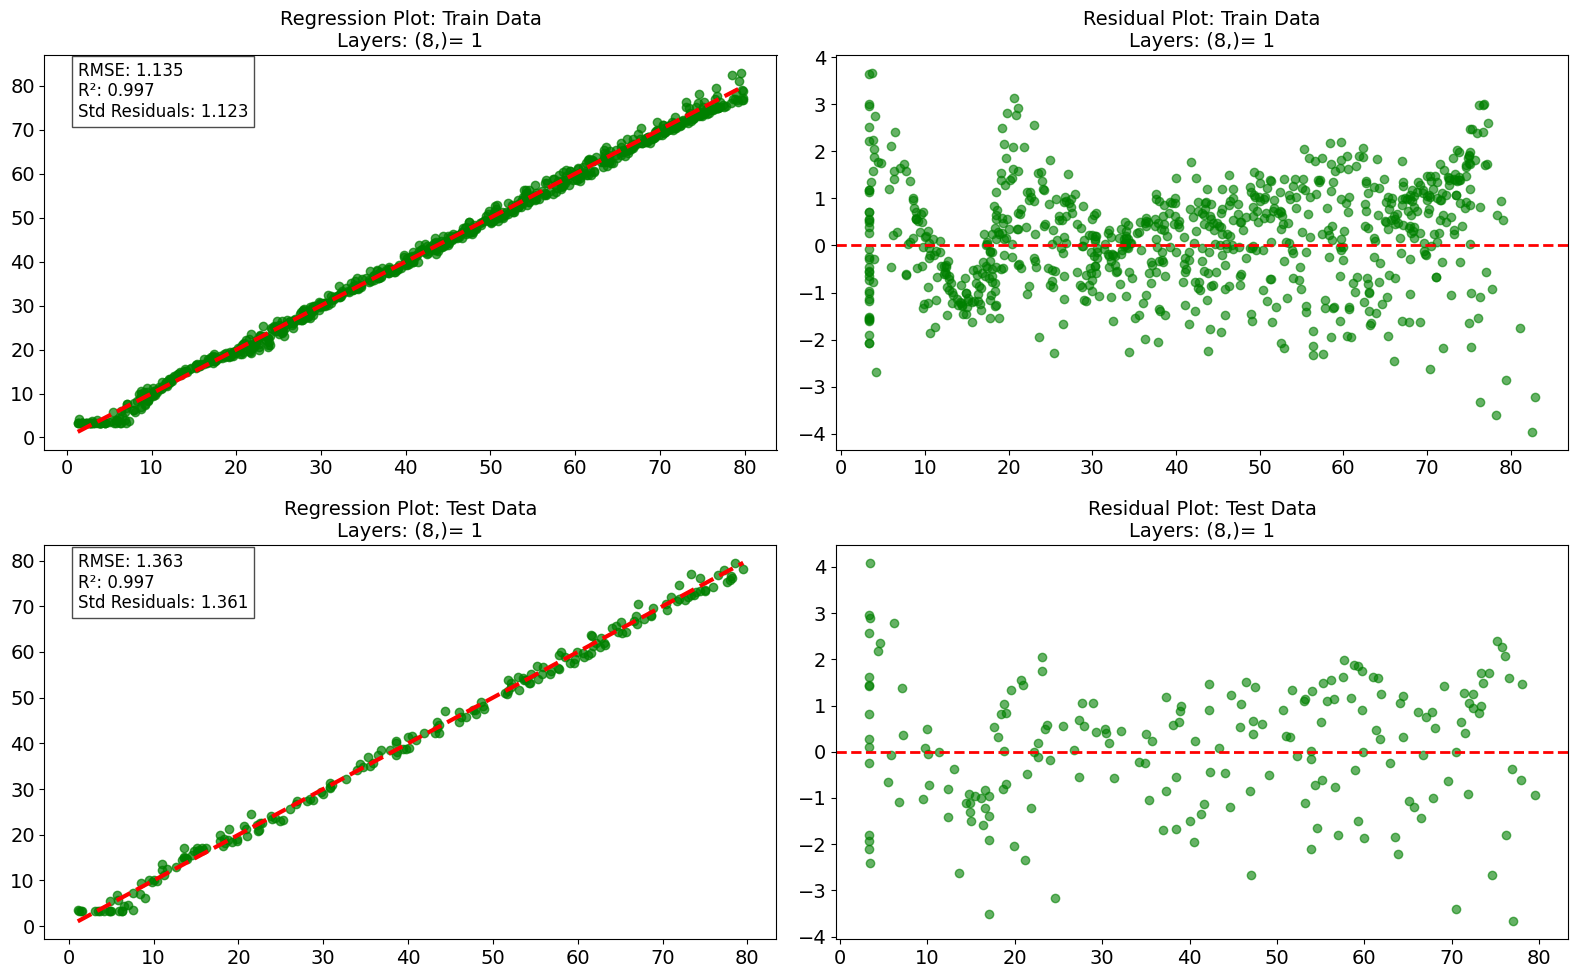

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


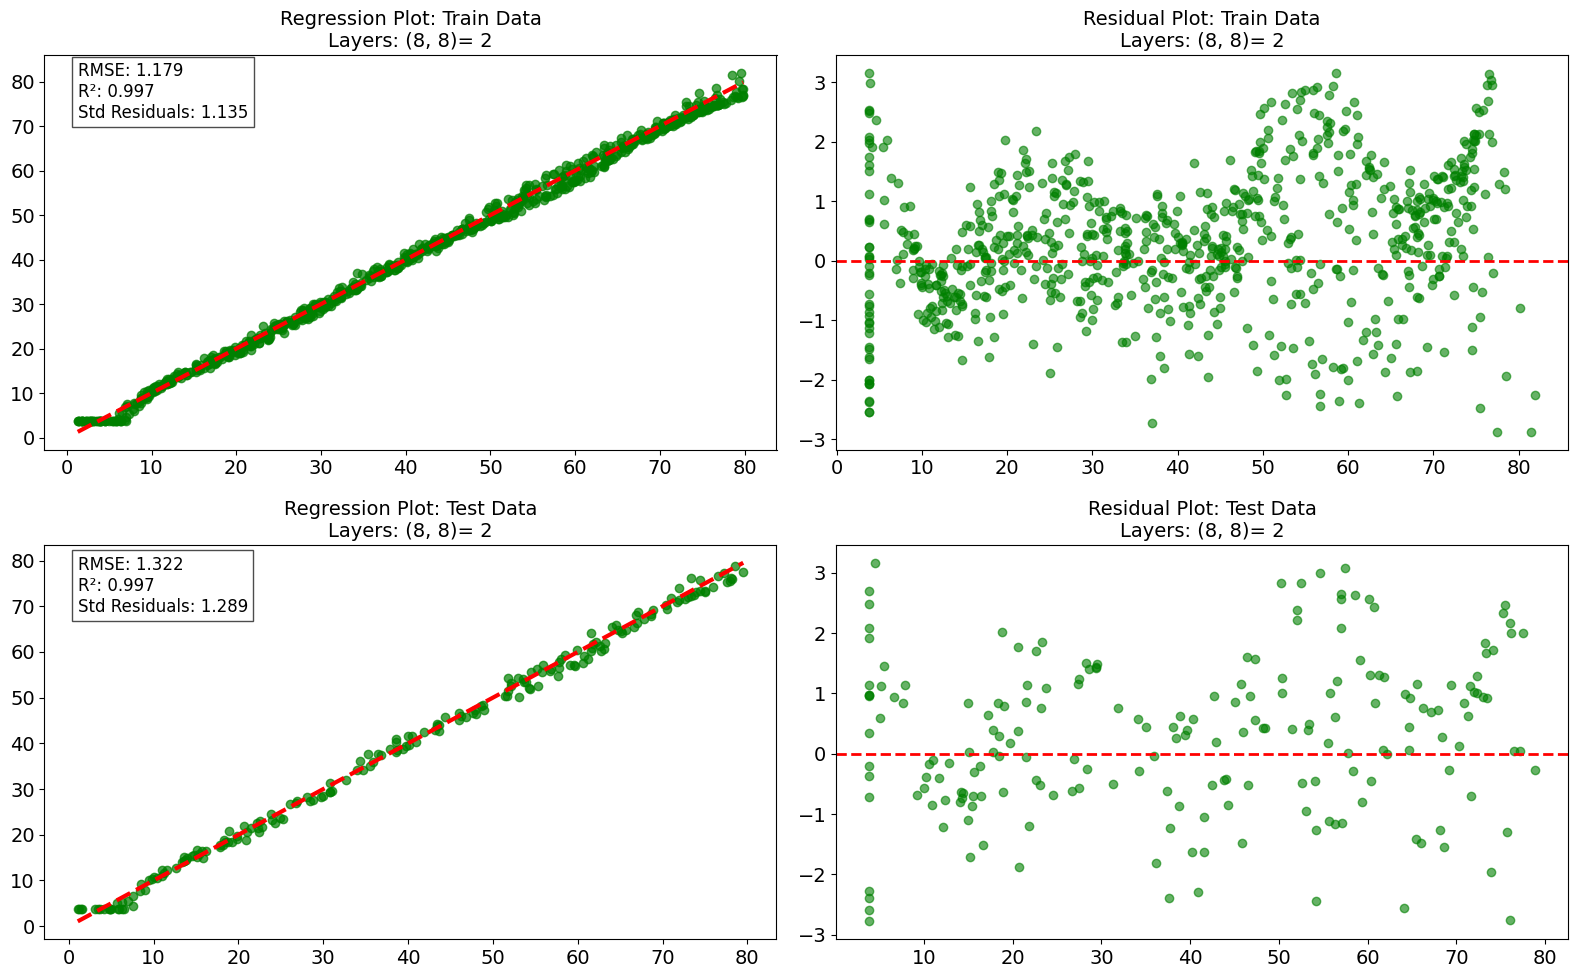

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


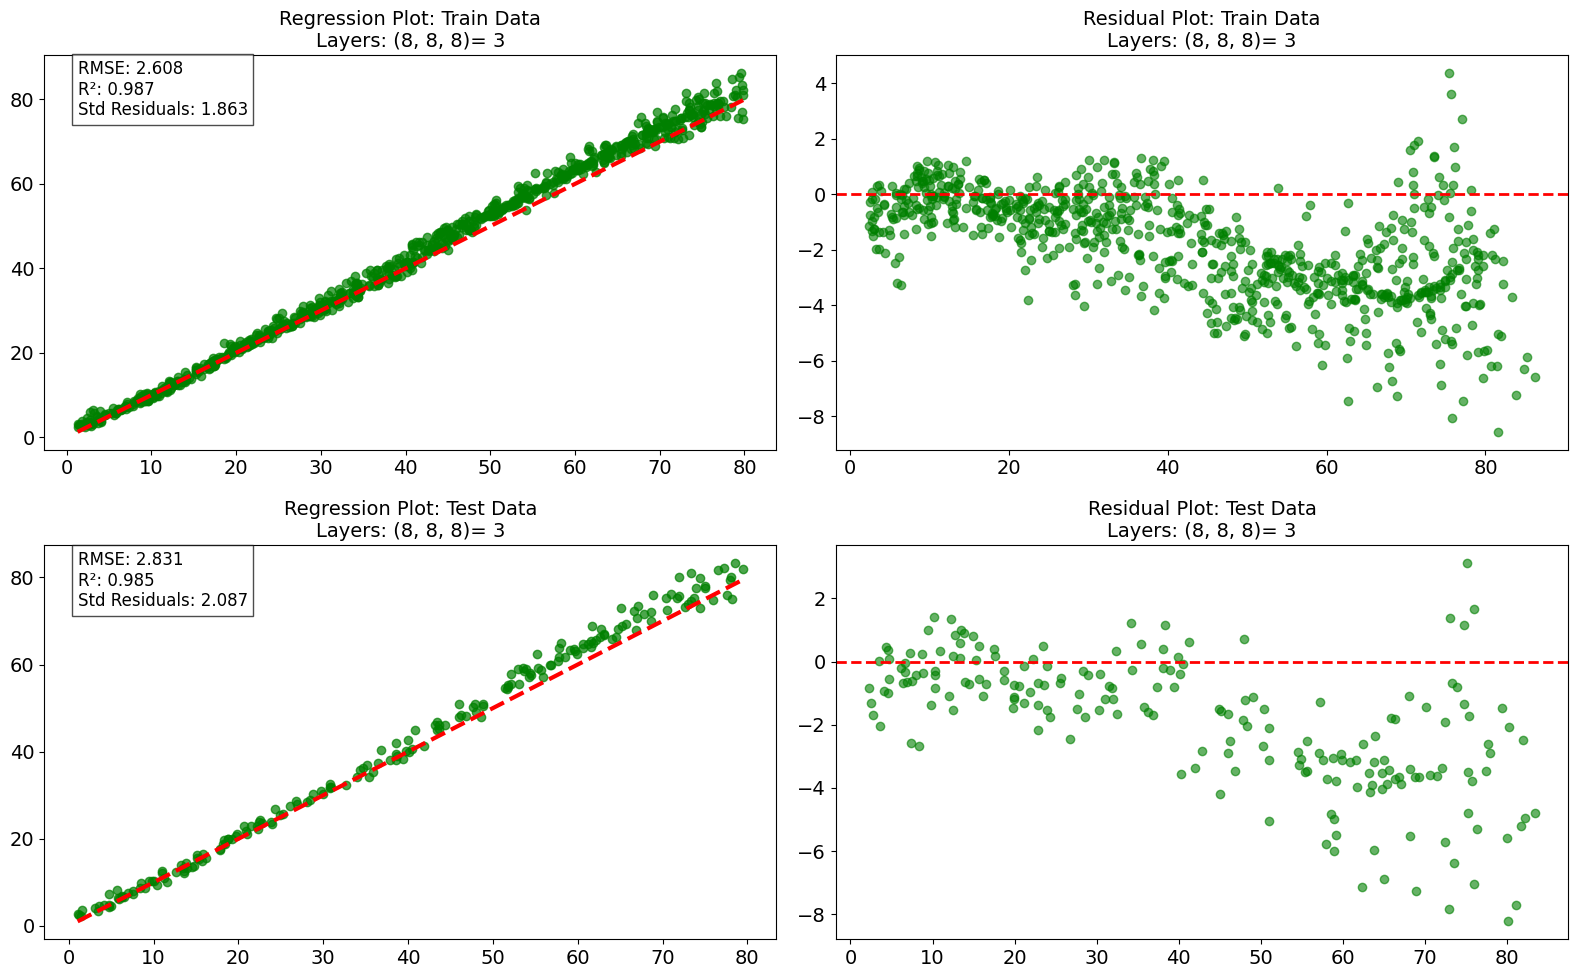

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


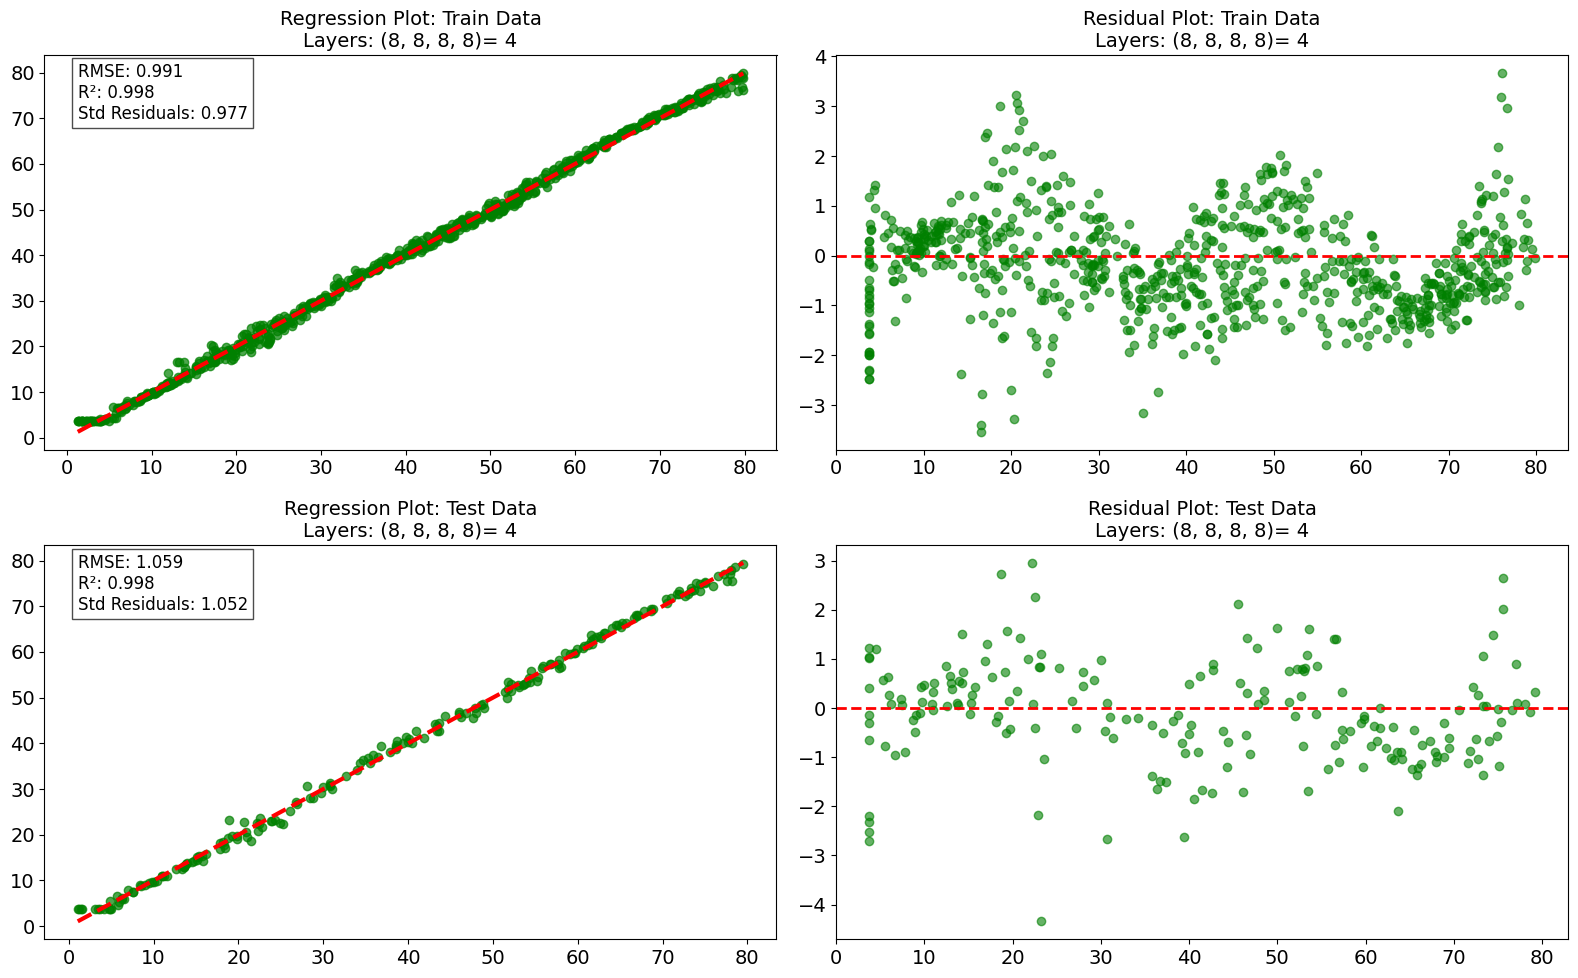

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


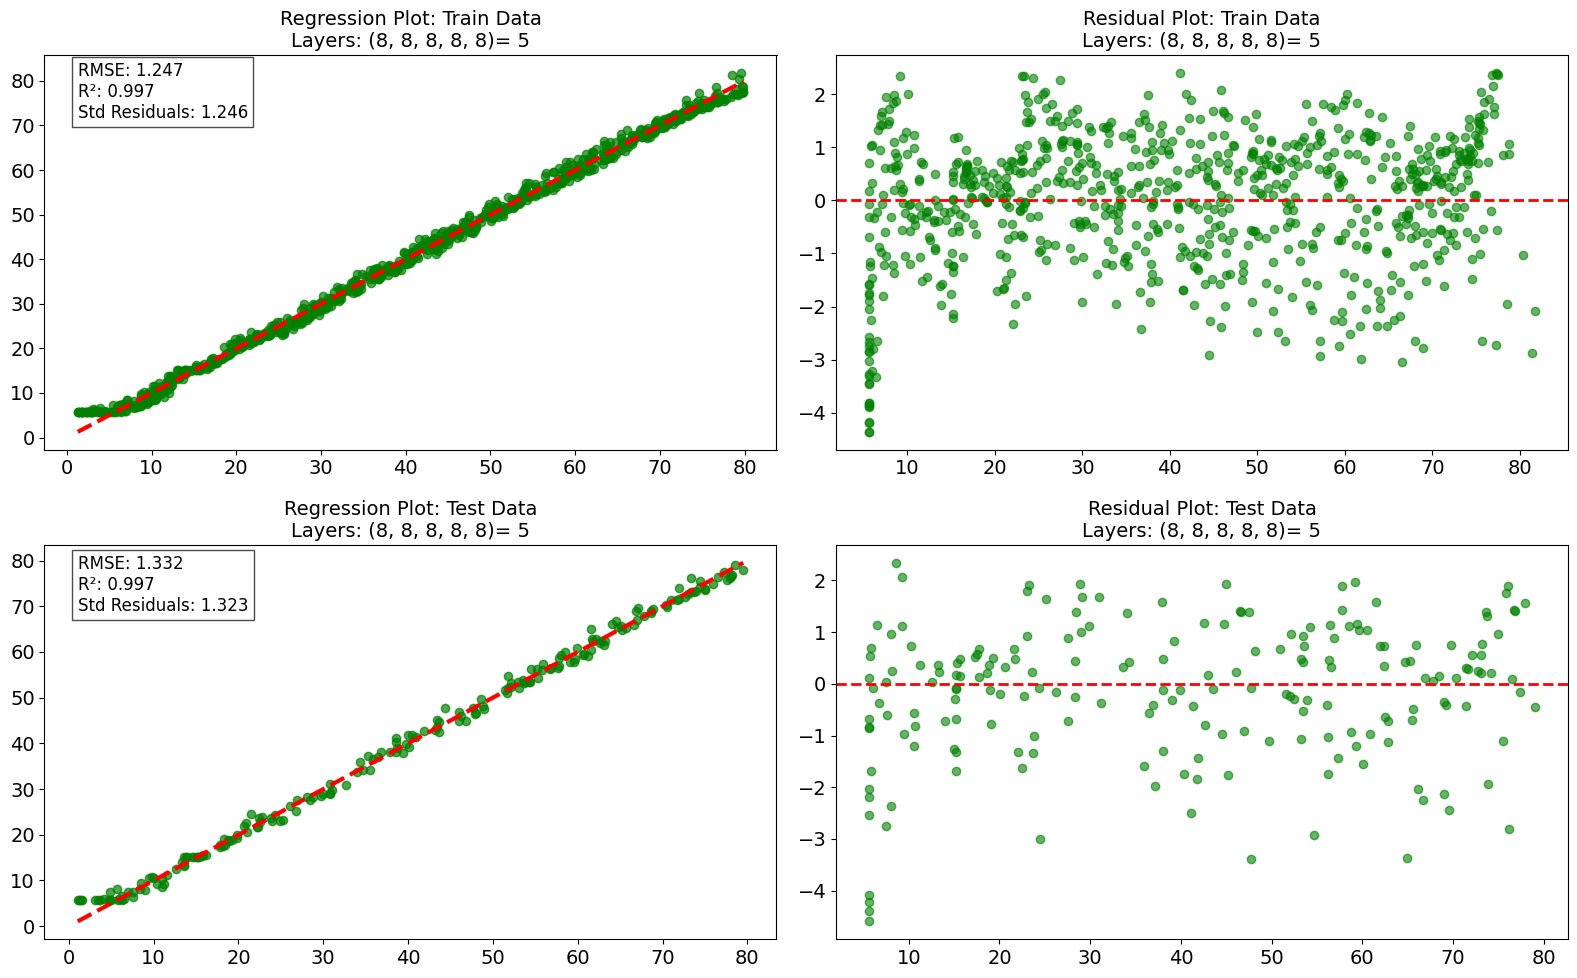

In [69]:
# Define layer configurations: From 1 to 5 hidden layers

i = 2             # Multiple of neurons in each layer
layer_configs = [(4*i,), (4*i, 4*i), (4*i, 4*i, 4*i), (4*i, 4*i, 4*i, 4*i), (4*i, 4*i, 4*i, 4*i, 4*i)] # Adding 1 layers each time
train_result = []
test_result = []

for layers in layer_configs:

    # Initialize MLP model
    mlp_model = MLPRegressor(hidden_layer_sizes=layers, activation='relu', learning_rate_init=0.1, max_iter=1000, random_state=42)
    
    # Train model
    mlp_model.fit(X_train, y_train)  
    
    # Predictions
    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)

    # Performance Metrics
    mlp_train_mae, mlp_train_r2, mlp_train_residuals_std = performance_metrics(y_train, y_train_pred)
    train_residuals = y_train -  y_train_pred

    mlp_test_mae, mlp_test_r2, mlp_test_residuals_std = performance_metrics(y_test, y_test_pred)
    test_residuals = y_test - y_test_pred

    # RMSE
    mlp_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    mlp_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Append Train and Test Results
    train_result.append((layers, mlp_train_rmse, mlp_train_r2, mlp_train_residuals_std, train_residuals))
    test_result.append((layers, mlp_test_rmse, mlp_test_r2, mlp_test_residuals_std, test_residuals))

    # Plot the results
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))

    ## Train    
    ax[0,0].scatter(y_train, y_train_pred, alpha=0.7, color='green')
    ax[0,0].set_title(f"Regression Plot: Train Data\nLayers: {layers}= {len(layers)}", fontsize=14)
    ax[0,0].text(min(y_train), max(y_train_pred)-10, 
                        f"RMSE: {mlp_train_rmse:.3f}\nR²: {mlp_train_r2:.3f}\nStd Residuals: {mlp_train_residuals_std:.3f}", 
                        bbox=dict(facecolor='white', alpha=0.7), fontsize=12)
    ax[0,0].plot([min(y_train), max(y_train)], 
                        [min(y_train), max(y_train)], 
                        color='red', linestyle='--', linewidth=3)
    ax[0,1].scatter(y_train_pred, train_residuals, alpha=0.6, color='green')
    ax[0,1].axhline(0, color='red', linestyle='--', linewidth=2)
    ax[0,1].set_title(f"Residual Plot: Train Data\nLayers: {layers}= {len(layers)}", fontsize=14)

    ## Test
    ax[1,0].scatter(y_test, y_test_pred, alpha=0.7, color='green')
    ax[1,0].set_title(f"Regression Plot: Test Data\nLayers: {layers}= {len(layers)}", fontsize=14)
    ax[1,0].text(min(y_test), max(y_test_pred)-10, 
                        f"RMSE: {mlp_test_rmse:.3f}\nR²: {mlp_test_r2:.3f}\nStd Residuals: {mlp_test_residuals_std:.3f}", 
                        bbox=dict(facecolor='white', alpha=0.7), fontsize=12)
    ax[1,0].plot([min(y_test), max(y_test)], 
                        [min(y_test), max(y_test)], 
                        color='red', linestyle='--', linewidth=3)
    ax[1,1].scatter(y_test_pred, test_residuals, alpha=0.6, color='green')
    ax[1,1].axhline(0, color='red', linestyle='--', linewidth=2)
    ax[1,1].set_title(f"Residual Plot: Test Data\nLayers: {layers}= {len(layers)}", fontsize=14)

    print('\033[1m' + '-' * 180 + '\033[0m')
    print('\033[1m' + '-' * 180 + '\033[0m')

    plt.tight_layout()
    plt.show()


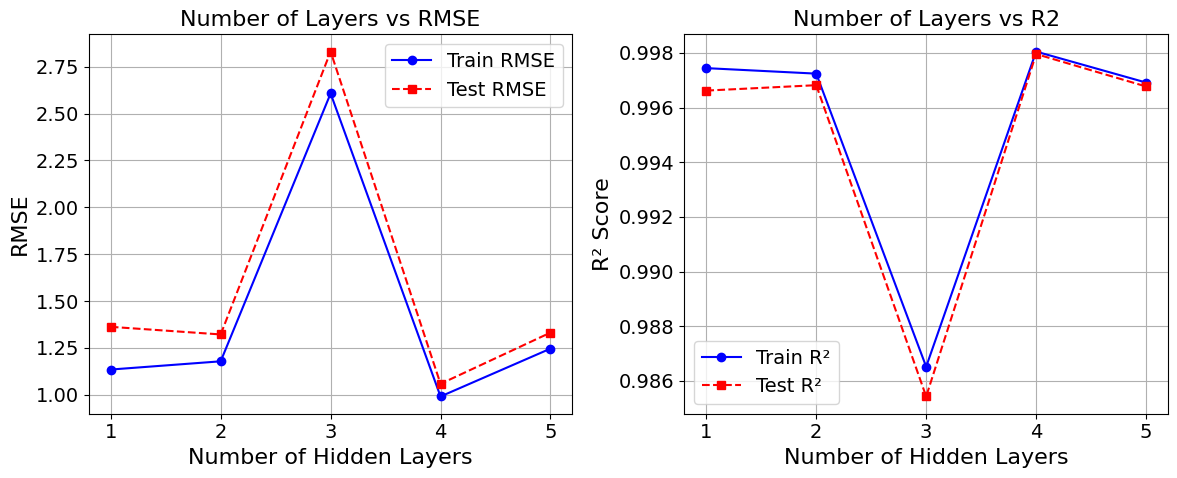

In [72]:
## Plot Num of layers vs RMSE and R2

# Extract results
num_layers = [len(layers) for layers, _, _, _, _ in train_result]

train_rmse = [rmse for _, rmse, _, _, _ in train_result]
test_rmse = [rmse for _, rmse, _, _, _ in test_result]

train_r2 = [r2 for _, _, r2, _, _ in train_result]
test_r2 = [r2 for _, _, r2, _, _ in test_result]

# Plot RGB and ground truth
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(num_layers, train_rmse, marker='o', linestyle='-', label='Train RMSE', color='blue')
ax[0].plot(num_layers, test_rmse, marker='s', linestyle='--', label='Test RMSE', color='red')
ax[0].set_xlabel('Number of Hidden Layers')
ax[0].set_ylabel('RMSE')
ax[0].set_title('Number of Layers vs RMSE')
ax[0].legend()
ax[0].grid()

ax[1].plot(num_layers, train_r2, marker='o', linestyle='-', label='Train R²', color='blue')
ax[1].plot(num_layers, test_r2, marker='s', linestyle='--', label='Test R²', color='red')
ax[1].set_xlabel('Number of Hidden Layers')
ax[1].set_ylabel('R² Score')
ax[1].set_title('Number of Layers vs R2')
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

**Comments: Multiple Layer Perceptron (MLP) Regressor** 

A *MLP* regressor model with varying number of hidden layer (1-5), *ReLU* activation function, and 8 neurons in each layers is used for predicting chlorophyll content using given 10 band data. MLPs are **Universal Function Estimators** and are able to learn the non-linearities in the data to give better predictions and generalization outcomes. This can be seen clearly from results above. The regression plots show that more than 99% of variance in actual chlorophyll content can explained by our model's prediction, both for train set and test sets. The non-linearity in the residuals is also greatly reduced as compared to earlier linear models. As we increase the depth (complexity) of model by increasing number of hidden layers its getting better in capturing non-linearity in the data, though some non-linearity is still present.

Although this type of perceptron based model are better in capturing the non-linearity present in the data, they generally need huge amount of data for reliable predictions and the demand for data increases exponentialy with the increase in number of hidden layers as well as number of perceptrons within a layer. We have just 1000 samples of data and the model performance till 4 hidden layer is increasing, however adding 5th layer is decreasing the performance as seen from our regression plot. The non-linearity in the residuals is still present but it is not as severe as previous cases. This shows the power of MLP regression models in *learning* the meaningful patterns in data and producing reliable outcomes.

---
---
</div>